# We Need Substitute Generators
Continuing along with my version of Dead By Daylight, we will need an object that the players need to worry about. In **Dead By Daylight**, players need to fix generators which are scattered around the world which is where the conflict between the Killers and the Survivors take place. In my game, these will be threads which connect the Torment's world to the players as described a bit in the original post.

I am unsure if the generators are hand placed spawns by their design which are then allocated out or if they really are simply random. I do know that at least some of them are hand placed; the Racoon City Police Station Lobby Generator as an example. However, at this time I've decided to make them randomly placed to try and prevent dedicated players from building out set paths or plans with which to camp.

## How To Place Them?
After a bit of thinking, I decided to try out a solution which draws from my Machine Learning studies: I will use **Drop Out** to generate noise, convert that noise to points and finally use **K Nearest Neighbors** to generate *Centroids* of the noise to place the threads. The rest of this post is going to go over how all this is done.

## Making Visualizations
Visualizations always make everything easier to reason about; this is why graphing is so useful to represent relationships. Therefore, we want to get pictures as fast as possible. I will represent the **Map** to be played on as a matrix of ones and then draw this just to make sure this works as intended; it will since I've done this a few times already but process is process.

In [1]:
# Get a 32x32 dimension tensor/matrix full of 1's
import torch
tiles = torch.ones([32,32])
tiles, tiles.shape

(tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 torch.Size([32, 32]))

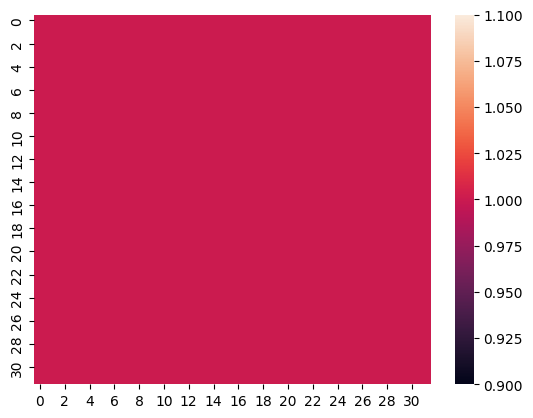

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Do the plotting thing
sns.heatmap(tiles);

Now we have a way to visualize *something* and can start working on the *Drop Out* part of this solution. In **Deep Learning**, **Drop Out** is a method of allowing these architectures to generalize better and they do this by simply randomly setting values to `0`. We can do a quick visualization to see this:

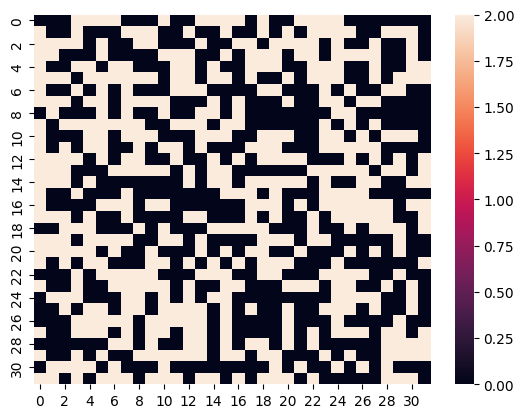

In [13]:
# Import the neural network stuff from pytorch
import torch.nn as nn

# drop some of the things!
m = nn.Dropout(.5)
dTiles = m(tiles)
sns.heatmap(dTiles);

The `.5` passed to `nn.Dropout` is saying "Please set half of the values in the tensor to 0 for me." I have done a bit of experimentation with this value and set it to `.2` - or 20% of the values are dropped. However, this does not appear to affect the results much. In the future, I'll do some proper testing and run this about 10000 times across the different drop out levels and see how much these deviate. For now, we are just making sure this idea works before considering properly fine tuning.

## Working Out Creating Threads
So, now that we have this image data we need to convert all this into data points. I looked around the Pytorch documentation to try and find a faster way to do this but in the end we are falling to a nested for loop across the rows. As we look through each row, we check if the value is a `0`` indicating a data point. And, then create a point out of the row and column index. At the end, we'll have our noise of points to feed into the algorithm.

In [4]:
import pandas as pd

points = []
for i, row in enumerate(dTiles):
    for y,v in enumerate((row == 0).int()):
        if v == 0:
            points.append( (i,y) )

noise = pd.DataFrame(points, columns=['x', 'y'])

Next the **K Nearest Neighbors** algorithm takes the noise of points and we tell it how many groups there should be. I'm skipping over how it works but you're welcome to [read more about it](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) if you so choose. What matters to us is that we would like three groups and therefore three points which represent the center of each group.

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(3, n_init=10) # added n_init to suppress warning
kmeans.fit(noise);

Once we have ran the `fit` method we can access the centers by acceesing the `.cluster_centers_` inside this fit object. Converting these points into a data frame and we can now plot to see if the results are sane.

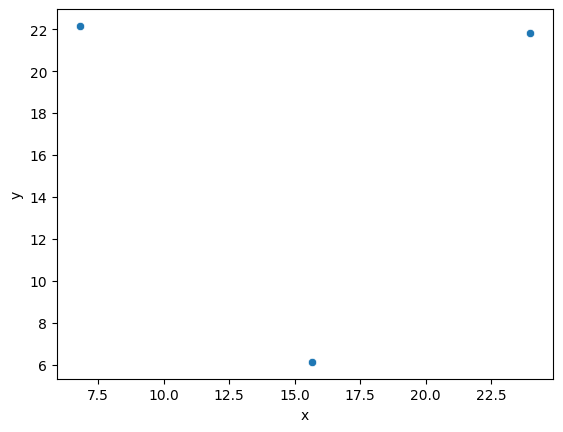

In [6]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['x', 'y'])
sns.scatterplot(centers, x='x', y='y');

There we go! Three points a reasonable distance away from one another which randomly changes every time we run the code. If we translate this to the tile system of a Pixel Art Map where there are 128 tiles horizontally and vertically we can test this generation method in a simple but handy loop.

### Iterative Loop

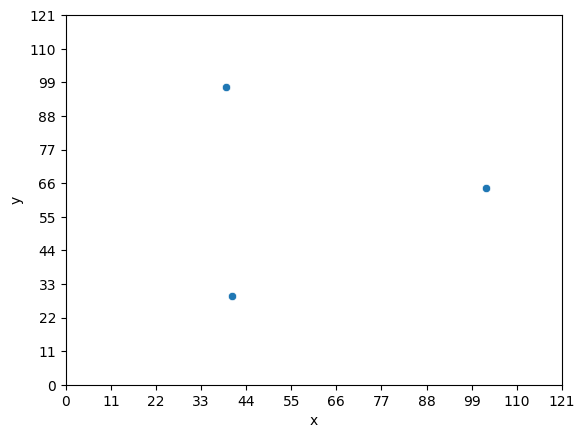

In [11]:
from math import sqrt, floor

# set the tileset map dimensions
dim = 128
level = torch.ones([dim,dim])

# how many points of noise are there?
dropout = nn.Dropout(.2)
levelNoise = dropout(level)

# create the (x,y) points
points = []
for i, row in enumerate(levelNoise):
    for y,v in enumerate((row == 0).int()):
        if v == 0:
            points.append( (i,y) )
noise = pd.DataFrame(points, columns=['x', 'y'])

# fit to find the centroids - which will be the "Threads"
kmeans = KMeans(3, n_init=10)
kmeans.fit(noise);

# pull and plot the locations
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['x', 'y'])
g = sns.scatterplot(centers, x='x', y='y')
g.set_xticks(range(0, dim, floor(sqrt(dim))))
g.set_yticks(range(0, dim, floor(sqrt(dim))))
g;

## Conclusive Thoughts
The solution works and quite well too!
There are some improvements to consider such as optimizing the distance between the points as well as fine tuning the *Drop Out* level. There is another problem though that the Raylib library I am using to build the game is in C++ and this all is in Python. Luckily, Pytorch is really written in C++ and then the bindings are built out for Python so most everything related to Pytorch is accessible in C++ via Torch. And, finding a usable open source library for *K Nearest Neighbor* is easy; I've already found one.

The next post will be about building a proper Make file to get all this joined together since I have never needed to start one from scratch. So, expect another post soon about getting torch and raylib together and maybe I'll have some gifs to share of walking around.